In [1]:
import csv
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline


# Exact and Approximate Bayesian Approaches

## Generating a posterior distribution

A Bayesian approach takes 3 inputs:
* A model for the data (parameters with uncertainty)
* A prior distribution of potential parameter values for the model
* Data

and provides 2 outputs:
* Posterior distribution on the model parameters
* Posterior predictive distribution (to predict new data)

We'll take example data that counts worker strikes in Argentina over the period 1984 to 1993 across different economic sectors. <sup><sub>Taken from McGuire J. W. (1996). Strikes in Argeintina: Data Srouces and Recent Trends. Lating American Research Review 31, 127-150</sup></sub>

For our prior, we will use a gamma distribution, which takes two parameters $\alpha$ and $\beta$.

For our model, we will use a Poisson distribution, which takes one parameter $\mu$.

We must decide on our gamma prior first (before seeing the data). In this example we choose $\alpha = 90, \beta = 1$.

We will use both an exact and an approximated Bayesian approach to find a probability distribution describing potential values for the model parameter $\mu$ (i.e. the posterior distribution).

In the plots, data is shown in green, the prior is shown in red, the exact Bayesian results are shown in green, and the approximate Bayesian results are shown in blue.

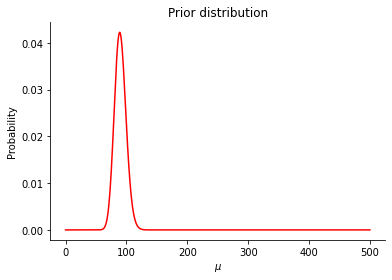

In [2]:
# Plot the prior distribution
domain = np.linspace(0, 500, 501)
alpha, beta = 90, 1
# scipy and numpy take theta (1/beta) rather than beta
prior = stats.gamma.pdf(domain, alpha, scale=(1/beta))
plt.xlabel(r'$\mu$')
plt.ylabel('Probability')
plt.title('Prior distribution')

plt.plot(domain, prior, c='r')
plt.show()

Our data is as follows:

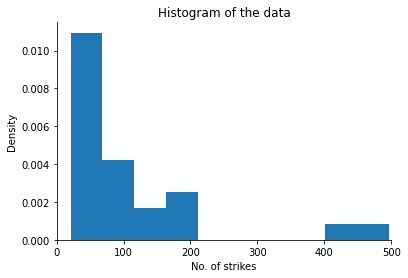

In [3]:
# Show the data
strikes = [496, 421, 199, 186, 181, 133, 128, 113, 92, 83, 77, 76, 57, 56, 55, 50, 47, 43, 39, 37, 32, 28, 26, 25, 21]

plt.hist(strikes, density=True)
plt.xlabel('No. of strikes')
plt.ylabel('Density')
plt.title('Histogram of the data')
plt.xlim(0, 500)
plt.show()

### Exact Bayesian approach

The posterior distribution is defined as

$p(\mu | y) \propto p(y | \mu) p(\mu)$

where $\mu$ is the model parameter and $y$ is the data.
This says the probability of the parameter $\mu$ given the data is proportional to the probability of the data given $\mu$ (the likelihood function for the Poisson model) multipled by the probablity of $\mu$ (the gamma prior).

So, we must take the likelihood equation for the Poisson model and multiply it by the equation for the prior model and normalise the result. This results in a new model that is

$\mu | y  \sim \textrm{Gamma}(\alpha + n\bar{y}, \beta + n)$

where $n$ is the total data points (in our case total economic sectors measured) and $\bar{y}$ is the mean of our data.


<sup><sub>Details on how those equations are multipled and produce a new gamma model are given here: https://vioshyvo.github.io/Bayesian_inference/conjugate-distributions.html#one-parameter-conjugate-models </sup></sub>

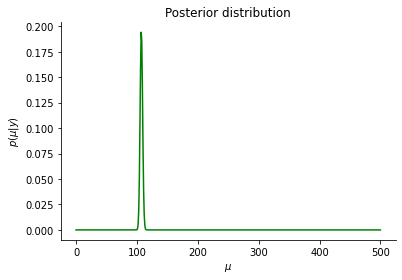

In [4]:
# Get the posterior
n = len(strikes)
alpha_prime = alpha + (n * np.mean(strikes))
beta_prime = beta + n
posterior = stats.gamma.pdf(domain, alpha_prime, scale=(1/beta_prime))

plt.xlabel(r'$\mu$')
plt.ylabel(r'$p(\mu | y)$')
plt.title('Posterior distribution')
plt.plot(domain, posterior, c='g')
plt.show()

This new gamma distribution is our posterior describing the probability of a given parameter $\mu$ fitting the Poisson model. The results show that a value just over 100 is the best fit given our prior and the data.

### Approximate Bayesian approach

Often our model is a black box model that cannot be described using an equation. We give it parameters, run it, and see what data we get out. In the exact Bayesian approach, to get our posterior distribution we muliplied the likelihood equation of the Poisson model by the equation of the prior. However, if there is no equation for the likelihood of the model then we cannot do this. Instead, we have to take an approximate sample-based approach.

In this example, we'll carry on using the Poisson distribution for our model but we'll pretend it's a black box that can't be defined by an equation.

We need to take a large number of samples from the prior (e.g. 10,000). Each sample is a possible candidate for the parameter $\mu$ in our model. For each sample, we run the model (create the Poisson distribution) and then calculate the likelihood of getting our data given the model. We do this by calculating the product of the probability mass of each data point in the model (or we can take the sum of the log of the probability masses). For an ABM, we would use some measure of error that compares our model output against our expected output.


Below is an example of one sample of $\mu$ taken from our prior. We create the Poisson model using $\mu$ and then measure the probability (y-axis) associated with each data point (x-axis) where the data mapping is shown in orange.

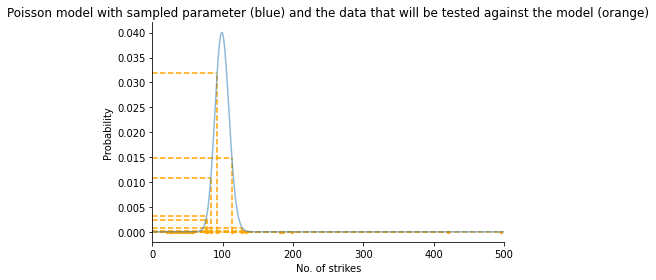

In [5]:
# Sample from prior
mu = np.random.gamma(alpha, scale=(1/beta))

# Create the model (run the model)
rv = stats.poisson(mu)

# Get the likelihood of the model given the data
likelihood = np.sum([-1 * np.log(rv.pmf(x)) for x in strikes])

plt.plot(domain, stats.poisson.pmf(domain, mu), alpha=0.5)
plt.scatter(strikes, [0 for _ in range(len(strikes))], c='orange', s=5)
for x in strikes:
    p = rv.pmf(x)
    plt.vlines(x, ymin=0, ymax=p, color='orange', linestyle='--')
    plt.hlines(y=p, xmin=0, xmax=x, color='orange', linestyle='--')
plt.xlabel('No. of strikes')
plt.ylabel('Probability')
plt.title('Poisson model with sampled parameter (blue) and the data that will be tested against the model (orange)')
plt.xlim(0, 500)

plt.tight_layout()
plt.show()

If the likelihood of a given parameter $\mu$ is below some acceptance threshold $e$ then we keep $\mu$, otherwise we discard it (this is called rejection sampling). How to choose a good value of $e$ requires some experimentation.

We repeat the process 10,000 times and can then plot the distribution of parameters that were kept. This is our approximate posterior distribution.

Total samples accepted: 1173


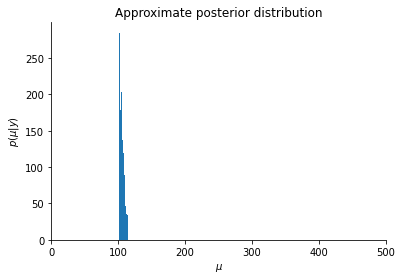

In [6]:
def approximate_posterior(e=1200):
    L = []
    np.random.seed(100)  # for reproducibility
    for _ in range(10000):
        # Sample from prior
        mu = np.random.gamma(alpha, scale=(1/beta))

        # Create the model (run the model)
        rv = stats.poisson(mu)

        # Get the likelihood of the model given the data
        likelihood = np.sum([-1 * np.log(rv.pmf(x)) for x in strikes])
        if likelihood < e:
            L.append(mu)
    print('Total samples accepted: %d' % len(L))
    return L

L = approximate_posterior(1200)
plt.xlim(min(domain), max(domain))
plt.xlabel(r'$\mu$')
plt.ylabel(r'$p(\mu | y)$')
plt.title('Approximate posterior distribution')
plt.hist(L)
plt.show()


## Comparing the exact and approximated posterior distributions

If we compare the posterior distribution using the two methods, we see they look quite similar. The green line is the posterior using traditional Bayes, and the blue is a histogram describing the posterior of the approximate method. 

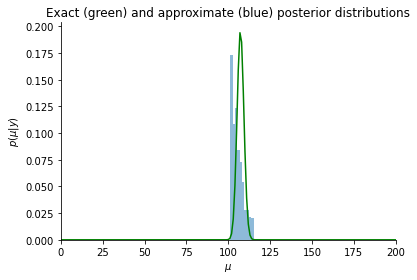

In [7]:
plt.xlabel(r'$\mu$')
plt.ylabel(r'$p(\mu | y)$')
plt.xlim(0, 200)
plt.title('Exact (green) and approximate (blue) posterior distributions')
plt.plot(domain, posterior, c='g')
plt.hist(L, density=True, alpha=0.5)
plt.show()

In the approximate Bayesian approach, if we increase $e$ we increase the threshold of how much error we will accept when comparing the data with the model and, as a result, more values of $\mu$ will be accepted.

In the plot below, the red line is the prior distribution that we are sampling $\mu$ from. The blue plot is a histogram of samples of $\mu$ that were accepted. For a low value of $e$, we only accept values of $\mu$ that are towards the top end of the prior, as these values result in a model that fits the data well. As we increase $e$, we start to accept lower values of $\mu$ which are a poorer fit for the data.

Total samples accepted: 1173
Total samples accepted: 8448


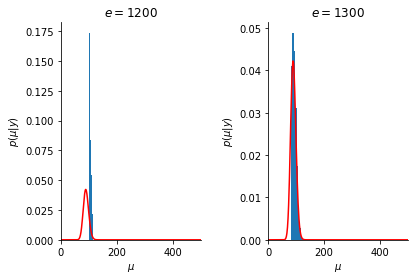

In [8]:
fig, axs = plt.subplots(1, 2)


for ax in axs:
    ax.set_xlim(min(domain), max(domain))
    ax.set_xlabel(r'$\mu$')
    ax.set_ylabel(r'$p(\mu | y)$')
    ax.plot(domain, prior, c='r')

L = approximate_posterior(1200)
axs[0].hist(L, density=True)
axs[0].set_title(r'$e = 1200$')

L = approximate_posterior(1300)
axs[1].hist(L, density=True)
axs[1].set_title(r'$e = 1300$')
plt.tight_layout()
plt.show()


## Posterior predictive distribution

We want to predict the distribution of new data. For example, how many strikes will occur in a different sector of Argentina over the same time period.

### Exact Bayesian approach

We have worked out that our posterior is a gamma distribution where

$\alpha' = \alpha + n \bar{y}$

$\beta' = \beta + n$

The posterior predictive distribution for some new data $\tilde{y}$ is

$p(\tilde{y} | y) = \int_\Omega p(\tilde{y}|\mu) p(\mu|y)\ d\mu$

which reduces to a negative binomial distribution:

$\tilde{y} | y \sim \textrm{Neg-Bin} \Big(\alpha', \frac{\beta'}{\beta' + 1}\Big)$

<sup><sub>(For the working out see: https://vioshyvo.github.io/Bayesian_inference/conjugate-distributions.html#poisson-pred)</sub></sup>

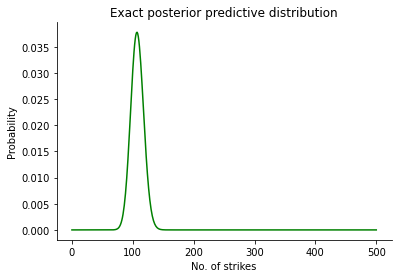

In [9]:
n = alpha_prime
p = beta_prime / (beta_prime + 1)
predictive_posterior = stats.nbinom.pmf(domain, n, p)
plt.xlabel('No. of strikes')
plt.ylabel('Probability')
plt.title('Exact posterior predictive distribution')
plt.plot(domain, predictive_posterior, c='g')
plt.show()

### Approximate Bayesian approach

In an approximate Bayesian approach, we cannot use equations as with a standard Bayes approach because our posterior is not defined as an equation, but instead by a collection of accepted parameters (i.e. values for $\mu$).

To generate an approxiamte predictive posterior distribution, we take each accepted value of $\mu$ and run our model (in this case create our Poisson distribution). We take an ensemble of samples (in this case we'll take 10 samples from the distribution) and store the results. The density of the results is then used as our predictive posterior distribution.

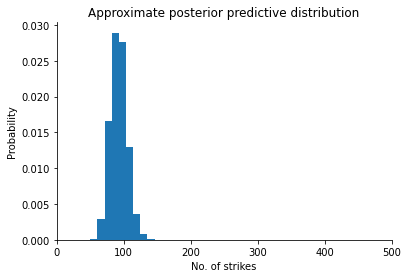

In [10]:
np.random.seed(100)  # for reproducibility
sampled_predictive_posterior = []
for mu in L:
    sampled_predictive_posterior.extend(np.random.poisson(mu, 10))  # do 10 samples

plt.xlim(0, 500)
plt.xlabel('No. of strikes')
plt.ylabel('Probability')
plt.title('Approximate posterior predictive distribution')
plt.hist(sampled_predictive_posterior, density=True)
plt.show()


Below we can see posterior preditive distribution taking the Bayesian approach (green) and the approximated approach (blue).

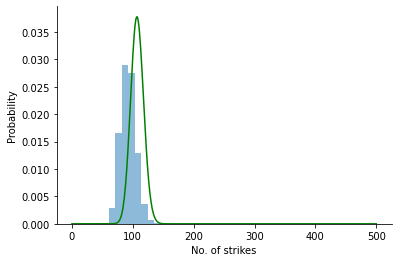

In [11]:
plt.xlabel('No. of strikes')
plt.ylabel('Probability')
plt.plot(domain, predictive_posterior, c='g')
plt.hist(sampled_predictive_posterior, density=True, alpha=0.5)
plt.show()